In [1]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import heliopy.data.spice as spicedata
import copy
import heliopy.spice as spice
import datetime
from datetime import timedelta
import astrospice
from astrospice.net.reg import RemoteKernel, RemoteKernelsBase
import astropy.units as u
from astropy.time import Time, TimeDelta
import astropy
import sunpy
from sunpy.time import parse_time
import os
from heliocats import data as hd
from bs4 import BeautifulSoup
import cdflib
from cdflib import epochs_astropy
import urllib.request
from urllib.request import urlopen
#importlib.reload(hd)

from sunpy.coordinates import HeliographicStonyhurst, HeliocentricEarthEcliptic
#import warnings

import importlib

wind_path = 'data/newdata/wind/'

print(astropy.__version__)

/Users/chris/python/miniconda3/envs/helio4/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


5.3.1


In [2]:
__all__ = ['BepiPredict']


class BepiPredict(RemoteKernelsBase):
    body = 'mpo'
    type = 'predict'

    def get_remote_kernels(self):
        """
        Returns
        -------
        list[RemoteKernel]
        """
        page = urlopen('https://naif.jpl.nasa.gov/pub/naif/BEPICOLOMBO/kernels/spk/')
        soup = BeautifulSoup(page, 'html.parser')

        kernel_urls = []
        for link in soup.find_all('a'):
            href = link.get('href')
            if href is not None and href.startswith('bc'):
                fname = href.split('/')[-1]
                matches = self.matches(fname)
                if matches:
                    kernel_urls.append(
                        RemoteKernel(f'https://naif.jpl.nasa.gov/pub/naif/BEPICOLOMBO/kernels/spk/{href}', *matches[1:]))

        return kernel_urls

    @staticmethod
    def matches(fname):
        """
        Check if the given filename matches the pattern of this kernel.

        Returns
        -------
        matches : bool
        start_time : astropy.time.Time
        end_time : astropy.time.Time
        version : int
        """
        # Example filename: bc_mpo_fcp_00154_20181020_20251102_v01.bsp 
        fname = fname.split('_')
        if (len(fname) != 7 or
                fname[0] != 'bc' or
                fname[1] != 'mpo' or
                fname[2] != 'fcp'):
            return False

        start_time = Time.strptime(fname[4], '%Y%m%d')
        end_time = Time.strptime(fname[5], '%Y%m%d')
        version = int(fname[6][1:3])
        return True, start_time, end_time, version


In [3]:
def wind_positions_heeq(start_year, path=wind_path):
    
    end = datetime.datetime.utcnow().date()

    files = os.listdir(wind_path)
    files.sort()
    data_files = [os.path.join(wind_path, f) for f in files]
            
    for i in np.arange(start_year, end.year+1, 1):
        
        #this is the path for the predicted orbits of Wind (predicted up to Sept. 30th 2023), GSE-coordinates in km
        data_url = f'https://spdf.gsfc.nasa.gov/pub/data/wind/orbit/pre_or/{i}/'
        soup = BeautifulSoup(urlopen(data_url), 'html.parser')
        for link in soup.find_all('a'):
            href = link.get('href')
            if href is not None and href.startswith('wi_or_pre_'):
                filename = href.split('/')[-1]
                fname = filename.split('_')
                date = fname[3]
                version = int(fname[4][1:3])
                
                if np.size(data_files)>0:
                    for i in range(1, len(data_files)):
                        fname_loc = data_files[i].split('_')
                        date_loc = fname_loc[3]
                        version_loc = int(fname_loc[4][1:3])
                        if date == date_loc and version != version_loc:
                            os.remove(data_files[i])
                            print('Deleted', data_files[i])
                
                if os.path.isfile(f"{path}{filename}") == True:
                    print(f'{filename} has already been downloaded.')
                
                else:
                    urllib.request.urlretrieve(data_url+href, f"{path}{filename}")
                    print(f'Successfully downloaded {filename}')


    files1 = os.listdir(wind_path)
    files1.sort()
    data_files1 = [os.path.join(wind_path, f) for f in files1]
    
    time_wind=np.zeros(0,dtype=[('time',object)])
    gse_x=np.zeros(0)
    gse_y=np.zeros(0)
    gse_z=np.zeros(0)

    for i in np.arange(1,len(data_files1)):
        wind_data = cdflib.CDF(data_files1[i])

        gse=wind_data.varget('GSE_POS')
        gse_x1=gse[:,0]*u.km.to(u.au)
        gse_y1=gse[:,1]*u.km.to(u.au)
        gse_z1=gse[:,2]*u.km.to(u.au)

        gse_x=np.append(gse_x,gse_x1)
        gse_y=np.append(gse_y,gse_y1)
        gse_z=np.append(gse_z,gse_z1)

        time_wind_epoch=wind_data.varget('Epoch')

        time_wind_datetime=parse_time(epochs_astropy.CDFAstropy.convert_to_astropy(time_wind_epoch, format=None)).datetime
        time_wind=np.append(time_wind,time_wind_datetime)
    
    #get Earth coordinates in HEE using astrospice
    #dt = 10min, because cdf-files have a 10min resolution as well
    dt = TimeDelta(10 * u.minute)
    
    times = Time(np.arange(Time(time_wind[0]), Time(time_wind[-1])+dt, dt))
    coords_earth = astrospice.generate_coords('Earth', times)
    coords_earth_hee = coords_earth.transform_to(HeliocentricEarthEcliptic())
    [earth_hee_x, earth_hee_y, earth_hee_z] = hd.sphere2cart(coords_earth_hee.distance.to(u.au).value, np.deg2rad(-coords_earth_hee.lat.value+90), np.deg2rad(coords_earth_hee.lon.value))
    
    wind = np.zeros(np.size(time_wind),dtype=[('time',object),('r','f8'),('lon','f8'),('lat','f8'),('x','f8'),('y','f8'),('z','f8')])
    wind = wind.view(np.recarray)
    wind.time = time_wind
    wind.x = earth_hee_x - gse_x
    wind.y = earth_hee_y - gse_y
    wind.z = earth_hee_z + gse_z
    
    wind = convert_HEE_to_HEEQ(wind)
    
    [wind.r, wind.lat, wind.lon] = hd.cart2sphere(wind.x, wind.y, wind.z)
    
    return wind

In [4]:
def convert_HEE_to_HEEQ(sc_in):
    '''
    for Wind positions: convert HEE to HAE to HEEQ
    '''

    print('conversion HEE to HEEQ')                                
    
    sc=copy.deepcopy(sc_in)
    
    jd=np.zeros(len(sc))
    mjd=np.zeros(len(sc))
        

    for i in np.arange(0,len(sc)):

        jd[i]=parse_time(sc.time[i]).jd
        mjd[i]=float(int(jd[i]-2400000.5)) #use modified julian date    
        
       
        w_hee=[sc.x[i],sc.y[i],sc.z[i]]
        
        #HEE to HAE        
        
        #define T00 and UT
        T00=(mjd[i]-51544.5)/36525.0          
        dobj=sc.time[i]
        UT=dobj.hour + dobj.minute / 60. + dobj.second / 3600. #time in UT in hours   

        #lambda_sun in Hapgood, equation 5, here in rad
        M=np.radians(357.528+35999.050*T00+0.04107*UT)
        LAMBDA=280.460+36000.772*T00+0.04107*UT        
        lambda_sun=np.radians( (LAMBDA+(1.915-0.0048*T00)*np.sin(M)+0.020*np.sin(2*M)) )
        
        #S-1 Matrix equation 12 hapgood 1992, change sign in lambda angle for inversion HEE to HAE instead of HAE to HEE
        c, s = np.cos(-(lambda_sun+np.radians(180))), np.sin(-(lambda_sun+np.radians(180)))
        Sm1 = np.array(((c,s, 0), (-s, c, 0), (0, 0, 1)))
        w_hae=np.dot(Sm1,w_hee)

        #HAE to HEEQ
        
        iota=np.radians(7.25)
        omega=np.radians((73.6667+0.013958*((mjd[i]+3242)/365.25)))                      
        theta=np.arctan(np.cos(iota)*np.tan(lambda_sun-omega))                       
                      
    
        #quadrant of theta must be opposite lambda_sun minus omega; Hapgood 1992 end of section 5   
        #get lambda-omega angle in degree mod 360 and theta in degrees
        lambda_omega_deg=np.mod(np.degrees(lambda_sun)-np.degrees(omega),360)
        theta_node_deg=np.degrees(theta)


        ##if the 2 angles are close to similar, so in the same quadrant, then theta_node = theta_node +pi           
        if np.logical_or(abs(lambda_omega_deg-theta_node_deg) < 1, abs(lambda_omega_deg-360-theta_node_deg) < 1): theta=theta+np.pi                                                                                                          
        
        #rotation around Z by theta
        c, s = np.cos(theta), np.sin(theta)
        S2_1 = np.array(((c,s, 0), (-s, c, 0), (0, 0, 1)))

        #rotation around X by iota  
        iota=np.radians(7.25)
        c, s = np.cos(iota), np.sin(iota)
        S2_2 = np.array(( (1,0,0), (0,c, s), (0, -s, c)) )
                
        #rotation around Z by Omega  
        c, s = np.cos(omega), np.sin(omega)
        S2_3 = np.array( ((c,s, 0), (-s, c, 0), (0, 0, 1)) )
        
        #matrix multiplication to go from HAE to HEEQ components                
        [x_heeq,y_heeq,z_heeq]=np.dot(  np.dot(   np.dot(S2_1,S2_2),S2_3), w_hae) 
        
        sc.x[i]=x_heeq
        sc.y[i]=y_heeq
        sc.z[i]=z_heeq

    
    print('HEE to HEEQ done')  
    
    return sc

In [18]:
def get_positions():
    #dt = TimeDelta(0.5*u.day)
    dt = TimeDelta(10*u.day)

    frame = HeliographicStonyhurst()
    
    ### PSP ###
    kernels_psp = astrospice.registry.get_kernels('psp', 'predict')
    psp_kernel = kernels_psp[0]
    # generate coordinates for whole time coverage in an hourly interval
    coverage_psp = psp_kernel.coverage('Solar probe plus')
    times_psp = Time(np.arange(coverage_psp[0], coverage_psp[1], dt))
    coords_psp = astrospice.generate_coords('Solar probe plus', times_psp)
    coords_psp = coords_psp.transform_to(frame)
    
    psp = np.zeros(np.size(times_psp),dtype=[('time',object),('r','f8'),('lon','f8'),('lat','f8'),('x','f8'),('y','f8'),('z','f8')])
    psp = psp.view(np.recarray)
    psp.time = times_psp.to_datetime(leap_second_strict='silent')
    psp.r = coords_psp.radius.to(u.au).value
    psp.lon = coords_psp.lon.value #degrees
    psp.lat = coords_psp.lat.value
    [psp.x, psp.y, psp.z] = hd.sphere2cart(psp.r, np.deg2rad(-psp.lat+90), np.deg2rad(psp.lon))
    
    
    ### SolO ###
    kernels_solo = astrospice.registry.get_kernels('solar orbiter', 'predict')
    solo_kernel = kernels_solo[0]
    coverage_solo = solo_kernel.coverage('Solar orbiter')
    times_solo = Time(np.arange(coverage_solo[0], coverage_solo[1], dt))
    coords_solo = astrospice.generate_coords('Solar orbiter', times_solo)
    coords_solo = coords_solo.transform_to(frame)
    
    solo = np.zeros(np.size(times_solo),dtype=[('time',object),('r','f8'),('lon','f8'),('lat','f8'),('x','f8'),('y','f8'),('z','f8')])
    solo = solo.view(np.recarray)
    solo.time = times_solo.to_datetime(leap_second_strict='silent')
    solo.r = coords_solo.radius.to(u.au).value
    solo.lon = coords_solo.lon.value #degrees
    solo.lat = coords_solo.lat.value
    [solo.x, solo.y, solo.z] = hd.sphere2cart(solo.r, np.deg2rad(-solo.lat+90), np.deg2rad(solo.lon))
    
    
    ### Stereo-A ###
    kernels_stereo_recon = astrospice.registry.get_kernels('stereo-a', 'recon')
    times_stereo_recon = Time(np.arange(Time('2006-10-27'), Time('2023-8-1'), dt))
    coords_stereo_recon = astrospice.generate_coords('Stereo ahead', times_stereo_recon)
    coords_stereo_recon = coords_stereo_recon.transform_to(frame)

    stereo_recon = np.zeros(np.size(times_stereo_recon),dtype=[('time',object),('r','f8'),('lon','f8'),('lat','f8'),('x','f8'),('y','f8'),('z','f8')])
    stereo_recon = stereo_recon.view(np.recarray)
    stereo_recon.time = times_stereo_recon.to_datetime(leap_second_strict='silent')
    stereo_recon.r = coords_stereo_recon.radius.to(u.au).value
    stereo_recon.lon = coords_stereo_recon.lon.value #degrees
    stereo_recon.lat = coords_stereo_recon.lat.value
    [stereo_recon.x, stereo_recon.y, stereo_recon.z] = hd.sphere2cart(stereo_recon.r, np.deg2rad(-stereo_recon.lat+90), np.deg2rad(stereo_recon.lon))
    
    kernels_stereo_pred = astrospice.registry.get_kernels('stereo-a', 'predict')
    stereo_kernel_pred = kernels_stereo_pred[0]
    coverage_stereo_pred = stereo_kernel_pred.coverage('Stereo ahead')
    times_stereo_pred = Time(np.arange(times_stereo_recon[-1]+dt, coverage_stereo_pred[1], dt))
    coords_stereo_pred = astrospice.generate_coords('Stereo ahead', times_stereo_pred)
    coords_stereo_pred = coords_stereo_pred.transform_to(frame)

    stereo_pred = np.zeros(np.size(times_stereo_pred),dtype=[('time',object),('r','f8'),('lon','f8'),('lat','f8'),('x','f8'),('y','f8'),('z','f8')])
    stereo_pred = stereo_pred.view(np.recarray)
    stereo_pred.time = times_stereo_pred.to_datetime(leap_second_strict='silent')
    stereo_pred.r = coords_stereo_pred.radius.to(u.au).value
    stereo_pred.lon = coords_stereo_pred.lon.value #degrees
    stereo_pred.lat = coords_stereo_pred.lat.value
    [stereo_pred.x, stereo_pred.y, stereo_pred.z] = hd.sphere2cart(stereo_pred.r, np.deg2rad(-stereo_pred.lat+90), np.deg2rad(stereo_pred.lon))

    stereo = np.zeros(np.size(times_stereo_recon)+np.size(times_stereo_pred),dtype=[('time',object),('r','f8'),('lon','f8'),('lat','f8'),('x','f8'),('y','f8'),('z','f8')])
    stereo = stereo.view(np.recarray)

    stereo.time=np.hstack((stereo_recon.time,stereo_pred.time))
    stereo.x=np.hstack((stereo_recon.x,stereo_pred.x))
    stereo.y=np.hstack((stereo_recon.y,stereo_pred.y))
    stereo.z=np.hstack((stereo_recon.z,stereo_pred.z))
    stereo.r=np.hstack((stereo_recon.r,stereo_pred.r))
    stereo.lon=np.hstack((stereo_recon.lon,stereo_pred.lon))
    stereo.lat=np.hstack((stereo_recon.lat,stereo_pred.lat))

    
    ### Bepi ###
    kernels_bepi = astrospice.registry.get_kernels('mpo', 'predict')
    bepi_kernel = kernels_bepi[0]
    coverage_bepi = bepi_kernel.coverage('Bepicolombo mpo')
    times_bepi = Time(np.arange(coverage_bepi[0], coverage_bepi[1], dt))
    coords_bepi = astrospice.generate_coords('Bepicolombo mpo', times_bepi)
    coords_bepi = coords_bepi.transform_to(frame)
    
    bepi_ = np.zeros(np.size(times_bepi),dtype=[('time',object),('r','f8'),('lon','f8'),('lat','f8'),('x','f8'),('y','f8'),('z','f8')])
    bepi_ = bepi_.view(np.recarray)
    bepi_.time = times_bepi.to_datetime(leap_second_strict='silent')
    bepi_.r = coords_bepi.radius.to(u.au).value
    bepi_.lon = coords_bepi.lon.value #degrees
    bepi_.lat = coords_bepi.lat.value
    [bepi_.x, bepi_.y, bepi_.z] = hd.sphere2cart(bepi_.r, np.deg2rad(-bepi_.lat+90), np.deg2rad(bepi_.lon))
    
    
    ### Earth ###
    times_earth = Time(np.arange(Time('1995-1-1'), Time(datetime.datetime.utcnow()), dt))
    coords_earth = astrospice.generate_coords('Earth', times_earth)
    coords_earth = coords_earth.transform_to(frame)
    
    earth = np.zeros(np.size(times_earth),dtype=[('time',object),('r','f8'),('lon','f8'),('lat','f8'),('x','f8'),('y','f8'),('z','f8')])
    earth = earth.view(np.recarray)
    earth.time = times_earth.to_datetime(leap_second_strict='silent')
    earth.r = coords_earth.radius.to(u.au).value
    earth.lon = coords_earth.lon.value #degrees
    earth.lat = coords_earth.lat.value
    [earth.x, earth.y, earth.z] = hd.sphere2cart(earth.r, np.deg2rad(-earth.lat+90), np.deg2rad(earth.lon))
    
    
    ### Wind ###
    wind = np.zeros(np.size(times_earth),dtype=[('time',object),('r','f8'),('lon','f8'),('lat','f8'),('x','f8'),('y','f8'),('z','f8')])
    wind = wind.view(np.recarray)
    wind.time = earth.time
    wind.x = earth.x - 0.01
    wind.y = earth.y
    wind.z = earth.z
    [wind.r, wind.lat, wind.lon] = hd.cart2sphere(wind.x, wind.y, wind.z)
    
    
    ### Mercury ###
    times_mercury = Time(np.arange(Time('1995-1-1'), Time(datetime.datetime.utcnow()), dt))
    coords_mercury = astrospice.generate_coords(1, times_mercury)
    coords_mercury = coords_mercury.transform_to(frame)
    
    mercury = np.zeros(np.size(times_mercury),dtype=[('time',object),('r','f8'),('lon','f8'),('lat','f8'),('x','f8'),('y','f8'),('z','f8')])
    mercury = mercury.view(np.recarray)
    mercury.time = times_mercury.to_datetime(leap_second_strict='silent')
    mercury.r = coords_mercury.radius.to(u.au).value
    mercury.lon = coords_mercury.lon.value #degrees
    mercury.lat = coords_mercury.lat.value
    [mercury.x, mercury.y, mercury.z] = hd.sphere2cart(mercury.r, np.deg2rad(-mercury.lat+90), np.deg2rad(mercury.lon))
    
    
    ### Venus ###
    times_venus = Time(np.arange(Time('1995-1-1'), Time(datetime.datetime.utcnow()), dt))
    coords_venus = astrospice.generate_coords(2, times_venus)
    coords_venus = coords_venus.transform_to(frame)
    
    venus = np.zeros(np.size(times_venus),dtype=[('time',object),('r','f8'),('lon','f8'),('lat','f8'),('x','f8'),('y','f8'),('z','f8')])
    venus = venus.view(np.recarray)
    venus.time = times_venus.to_datetime(leap_second_strict='silent')
    venus.r = coords_venus.radius.to(u.au).value
    venus.lon = coords_venus.lon.value #degrees
    venus.lat = coords_venus.lat.value
    [venus.x, venus.y, venus.z] = hd.sphere2cart(venus.r, np.deg2rad(-venus.lat+90), np.deg2rad(venus.lon))
    
    
    ### Mars ###
    times_mars = Time(np.arange(Time('2000-1-1'), Time(datetime.datetime.utcnow()), dt))
    coords_mars = astrospice.generate_coords(4, times_mars)
    coords_mars = coords_mars.transform_to(frame)

    mars = np.zeros(np.size(times_mars),dtype=[('time',object),('r','f8'),('lon','f8'),('lat','f8'),('x','f8'),('y','f8'),('z','f8')])
    mars = mars.view(np.recarray)
    mars.time = times_mars.to_datetime(leap_second_strict='silent')
    mars.r = coords_mars.radius.to(u.au).value
    mars.lon = coords_mars.lon.value #degrees
    mars.lat = coords_mars.lat.value
    [mars.x, mars.y, mars.z] = hd.sphere2cart(mars.r, np.deg2rad(-mars.lat+90), np.deg2rad(mars.lon))
    
    
    ### Jupiter ###
    times_jupiter = Time(np.arange(Time('1995-1-1'), Time(datetime.datetime.utcnow()), dt))
    coords_jupiter = astrospice.generate_coords(5, times_jupiter)
    coords_jupiter = coords_jupiter.transform_to(frame)
    
    jupiter = np.zeros(np.size(times_jupiter),dtype=[('time',object),('r','f8'),('lon','f8'),('lat','f8'),('x','f8'),('y','f8'),('z','f8')])
    jupiter = jupiter.view(np.recarray)
    jupiter.time = times_jupiter.to_datetime(leap_second_strict='silent')
    jupiter.r = coords_jupiter.radius.to(u.au).value
    jupiter.lon = coords_jupiter.lon.value #degrees
    jupiter.lat = coords_jupiter.lat.value
    [jupiter.x, jupiter.y, jupiter.z] = hd.sphere2cart(jupiter.r, np.deg2rad(-jupiter.lat+90), np.deg2rad(jupiter.lon))
    
    
    ### Saturn ###
    times_saturn = Time(np.arange(Time('1995-1-1'), Time(datetime.datetime.utcnow()), dt))
    coords_saturn = astrospice.generate_coords(6, times_saturn)
    coords_saturn = coords_saturn.transform_to(frame)
    
    saturn = np.zeros(np.size(times_saturn),dtype=[('time',object),('r','f8'),('lon','f8'),('lat','f8'),('x','f8'),('y','f8'),('z','f8')])
    saturn = saturn.view(np.recarray)
    saturn.time = times_saturn.to_datetime(leap_second_strict='silent')
    saturn.r = coords_saturn.radius.to(u.au).value
    saturn.lon = coords_saturn.lon.value #degrees
    saturn.lat = coords_saturn.lat.value
    [saturn.x, saturn.y, saturn.z] = hd.sphere2cart(saturn.r, np.deg2rad(-saturn.lat+90), np.deg2rad(saturn.lon))
    
    
    ### Uranus ###
    times_uranus = Time(np.arange(Time('1995-1-1'), Time(datetime.datetime.utcnow()), dt))
    coords_uranus = astrospice.generate_coords(7, times_uranus)
    coords_uranus = coords_uranus.transform_to(frame)
    
    uranus = np.zeros(np.size(times_uranus),dtype=[('time',object),('r','f8'),('lon','f8'),('lat','f8'),('x','f8'),('y','f8'),('z','f8')])
    uranus = uranus.view(np.recarray)
    uranus.time = times_uranus.to_datetime(leap_second_strict='silent')
    uranus.r = coords_uranus.radius.to(u.au).value
    uranus.lon = coords_uranus.lon.value #degrees
    uranus.lat = coords_uranus.lat.value
    [uranus.x, uranus.y, uranus.z] = hd.sphere2cart(uranus.r, np.deg2rad(-uranus.lat+90), np.deg2rad(uranus.lon))
    
    
    ### Neptune ###
    times_neptune = Time(np.arange(Time('1995-1-1'), Time(datetime.datetime.utcnow()), dt))
    coords_neptune = astrospice.generate_coords(8, times_neptune)
    coords_neptune = coords_neptune.transform_to(frame)
    
    neptune = np.zeros(np.size(times_neptune),dtype=[('time',object),('r','f8'),('lon','f8'),('lat','f8'),('x','f8'),('y','f8'),('z','f8')])
    neptune = neptune.view(np.recarray)
    neptune.time = times_neptune.to_datetime(leap_second_strict='silent')
    neptune.r = coords_neptune.radius.to(u.au).value
    neptune.lon = coords_neptune.lon.value #degrees
    neptune.lat = coords_neptune.lat.value
    [neptune.x, neptune.y, neptune.z] = hd.sphere2cart(neptune.r, np.deg2rad(-neptune.lat+90), np.deg2rad(neptune.lon))  
    
    return psp, solo, stereo, bepi_, wind, earth, mercury, venus, mars, jupiter, saturn, uranus, neptune  #wind


### SAVE SPACECRAFT POSITIONS ###

psp, solo, stereo, bepi_, wind, earth, mercury, venus, mars, jupiter, saturn, uranus, neptune = get_positions()

#pickle.dump([psp, solo, stereo, bepi_, wind, earth, mercury, venus, mars, jupiter, saturn, uranus, neptune], open( 'data/newdata/positions_psp_solo_sta_bepi_wind_planets_HEEQ_1hour.p', "wb" ) ) 

Files Downloaded: 100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 11.15file/s]
/Users/chris/python/miniconda3/envs/helio4/lib/python3.10/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "utctai" yielded 142 of "dubious year (Note 3)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/Users/chris/python/miniconda3/envs/helio4/lib/python3.10/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "taiutc" yielded 142 of "dubious year (Note 4)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/Users/chris/python/miniconda3/envs/helio4/lib/python3.10/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "d2dtf" yielded 142 of "dubious year (Note 5)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
Files Downloaded:  94%|████████████████████████████████████████▎  | 15/16 [00:01<00:00,  8.02file/s]


1/0 files failed to download. Please check `.errors` for details


Files Downloaded: 100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.49file/s]
/Users/chris/python/miniconda3/envs/helio4/lib/python3.10/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "utctai" yielded 170 of "dubious year (Note 3)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/Users/chris/python/miniconda3/envs/helio4/lib/python3.10/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "taiutc" yielded 170 of "dubious year (Note 4)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/Users/chris/python/miniconda3/envs/helio4/lib/python3.10/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "d2dtf" yielded 170 of "dubious year (Note 5)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
Files Downloaded: 100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.38file/s]


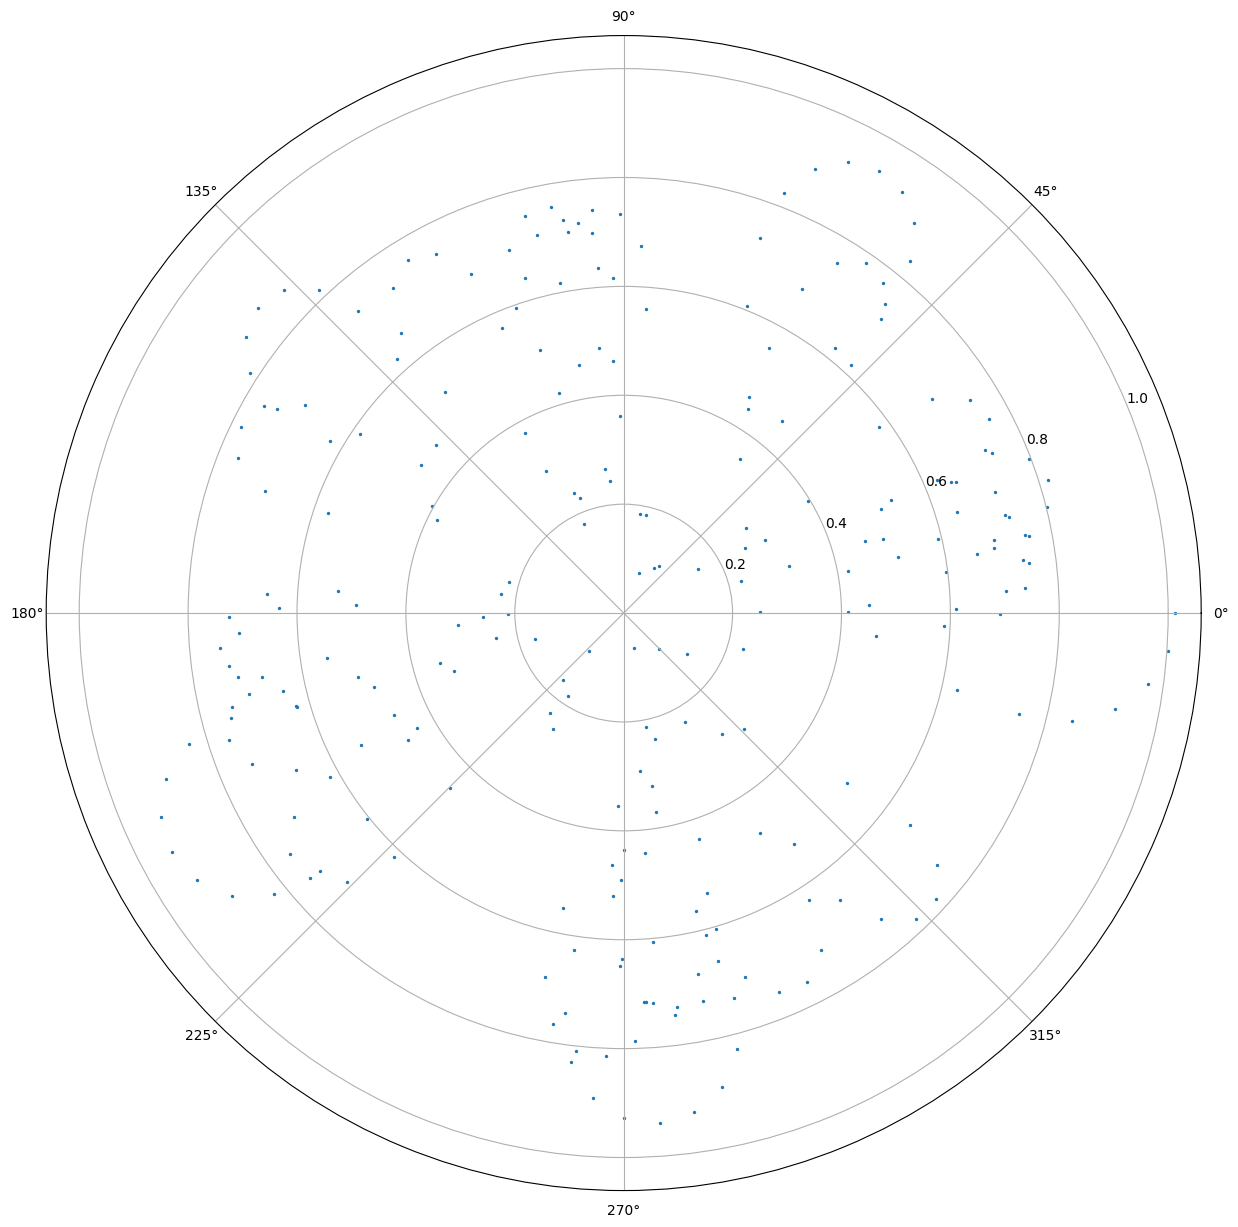

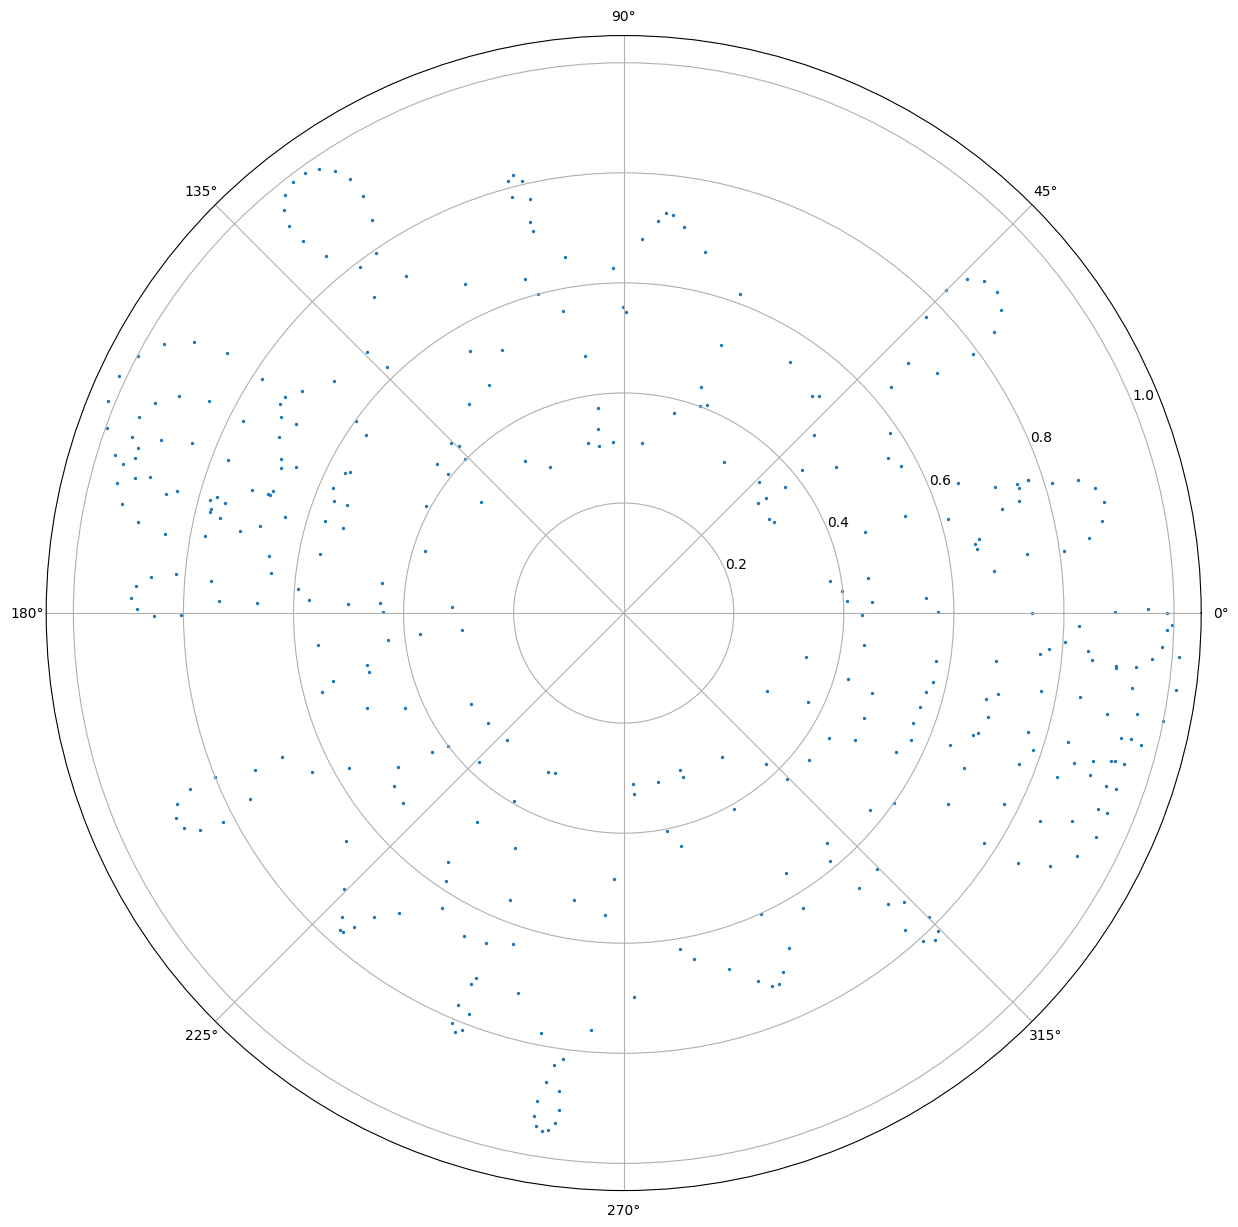

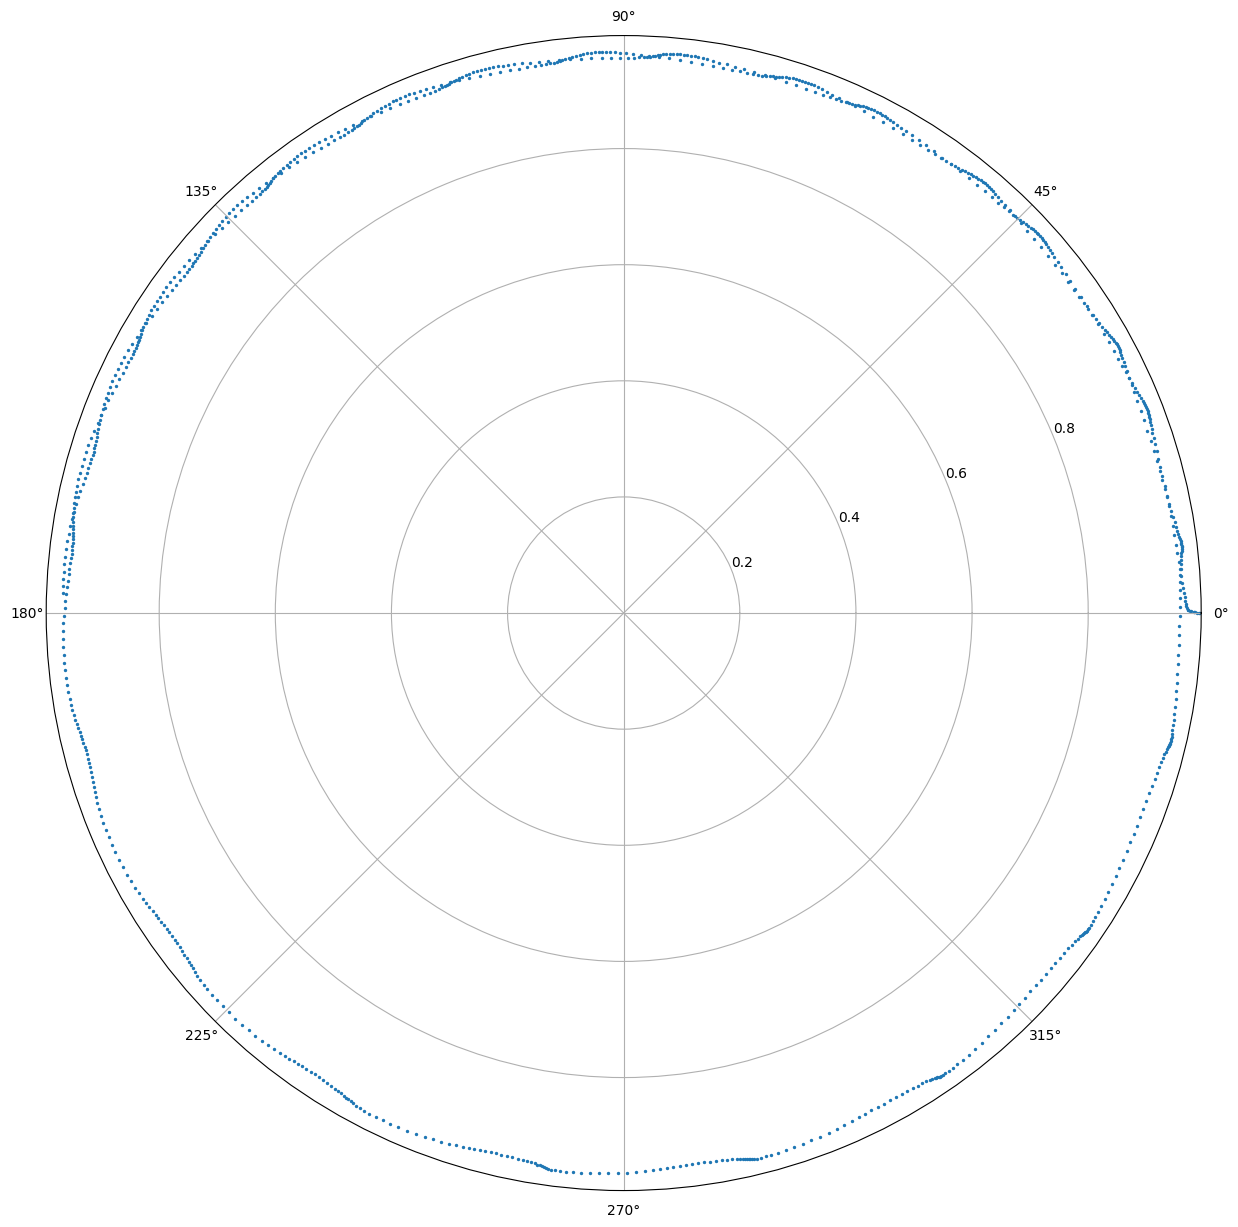

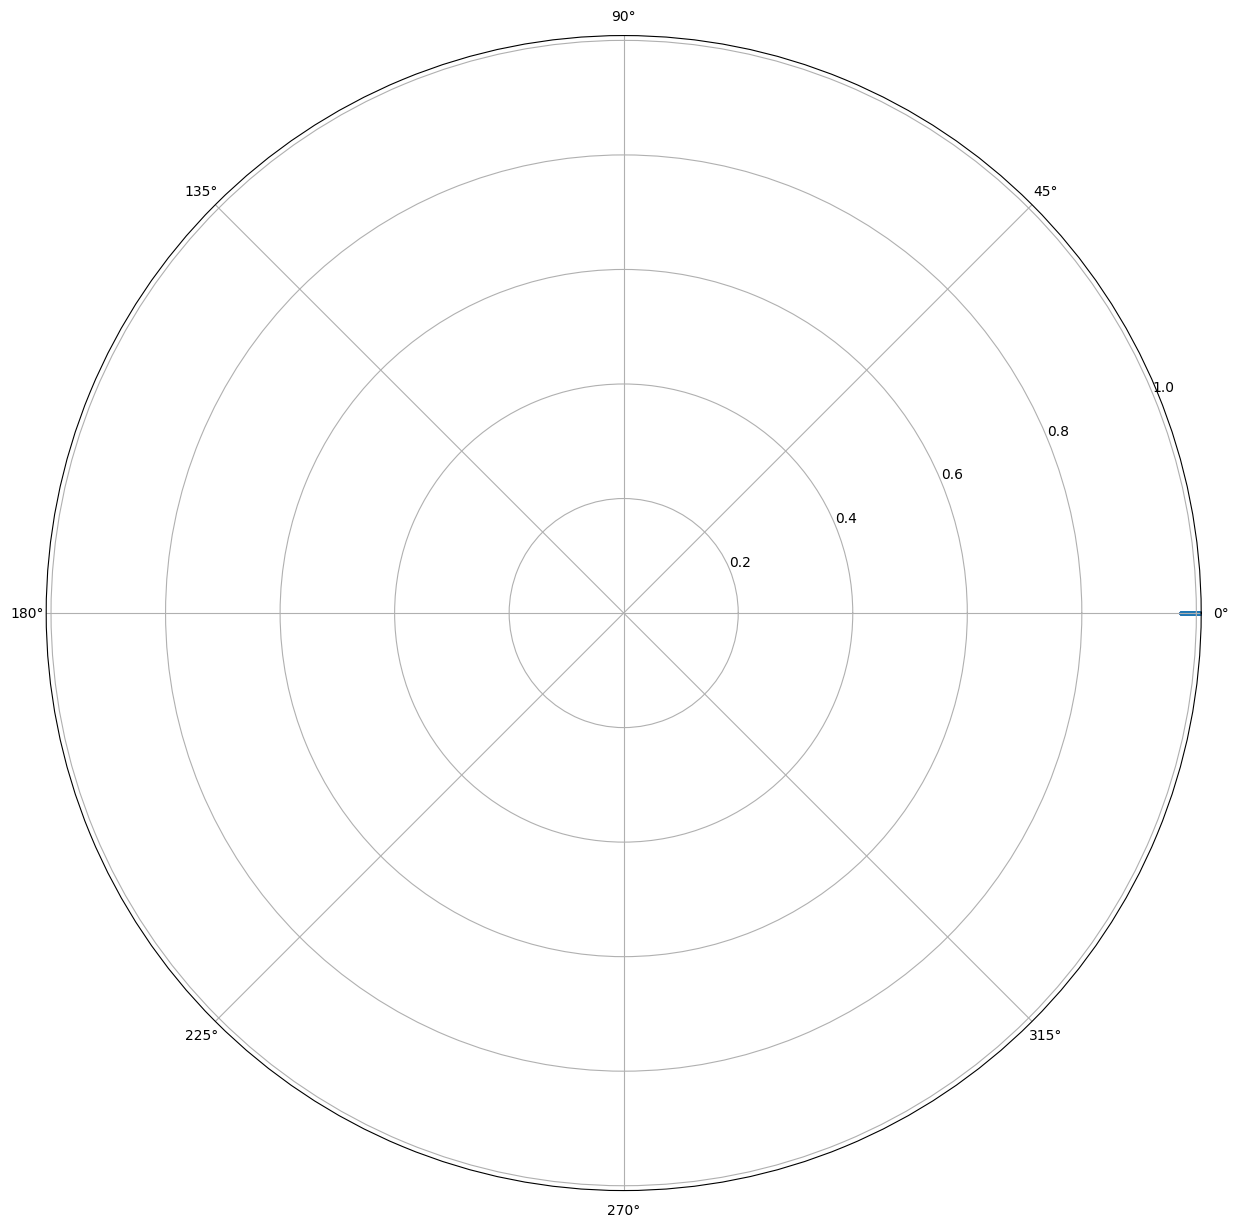

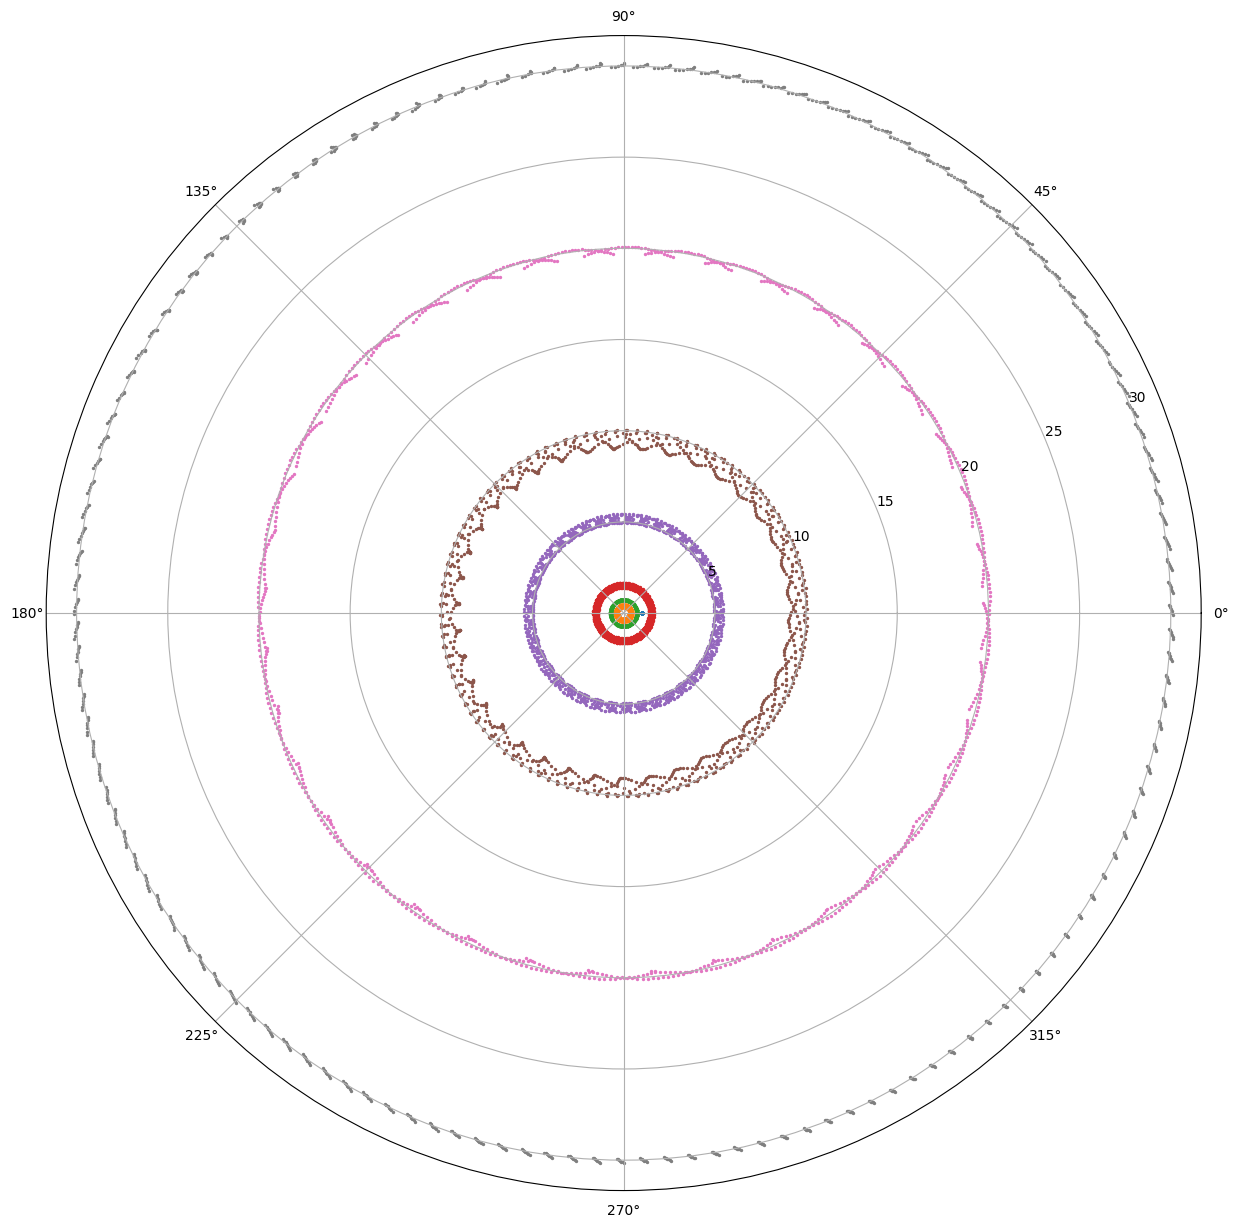

In [19]:
#### PLOT SPACECRAFT POSITIONS ####

fig = plt.figure(1, figsize=(15,15), dpi=100)
ax = fig.add_subplot(projection='polar')
ax.scatter(np.deg2rad(psp.lon), psp.r, s=2)
plt.show()

fig = plt.figure(2, figsize=(15,15), dpi=100)
ax = fig.add_subplot(projection='polar')
ax.scatter(np.deg2rad(solo.lon), solo.r, s=2)
plt.show()

fig = plt.figure(3, figsize=(15,15), dpi=100)
ax = fig.add_subplot(projection='polar')
ax.scatter(np.deg2rad(stereo.lon), stereo.r, s=2)
plt.show()

fig = plt.figure(4, figsize=(15,15), dpi=100)
ax = fig.add_subplot(projection='polar')
ax.scatter(np.deg2rad(wind.lon), wind.r, s=2)

plt.show()
fig = plt.figure(5, figsize=(15,15), dpi=100)
ax = fig.add_subplot(projection='polar')
ax.scatter(np.deg2rad(earth.lon), earth.r, s=2)
ax.scatter(np.deg2rad(mercury.lon), mercury.r, s=2)
ax.scatter(np.deg2rad(venus.lon), venus.r, s=2)
ax.scatter(np.deg2rad(mars.lon), mars.r, s=2)
ax.scatter(np.deg2rad(jupiter.lon), jupiter.r, s=2)
ax.scatter(np.deg2rad(saturn.lon), saturn.r, s=2)
ax.scatter(np.deg2rad(uranus.lon), uranus.r, s=2)
ax.scatter(np.deg2rad(neptune.lon), neptune.r, s=2)
plt.show()

In [34]:
print(earth.lat)
print(wind.lat)


[-2.98826628 -4.10889755 -5.09982982 ...  4.0812825   5.01820562
  5.81805333]
[-0.05269068 -0.07244987 -0.08992141 ...  0.07193885  0.08845367
  0.10255286]


In [31]:
wind.lon

array([ 8.02852219e-07,  8.17637999e-07,  8.06610210e-07, ...,
       -8.16197897e-07, -8.15141309e-07, -7.88934261e-07])